### Amazon product review data processing

We use this website to get data: http://jmcauley.ucsd.edu/data/amazon/

Given that we want to test the power of transfer learning with the idea that it could prove useful to pretrain networks on review categories with lots of data to improve prediction performance on categories with less data, we choose the Amazon product category with the largest amount of data - books.

We download the file from the section labeled _"Small" subsets for experimentation_ with the title  _Books	5-core (8,898,041 reviews)_.

The file is saved in the data directory, but not tracked in this Github repository due to filesize limitations. The downloaded file name is `reviews_Books_5.json.gz`. It can be downloaded to the correct location from here with the following command:

In [1]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz -P ./data/amazon

--2022-07-19 02:45:36--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3223678899 (3.0G) [application/x-gzip]
Saving to: ‘./data/reviews_Books_5.json.gz’

reviews_Books_5.jso 100%[===================>]   3.00G  47.6MB/s    in 72s     

2022-07-19 02:46:48 (42.7 MB/s) - ‘./data/reviews_Books_5.json.gz’ saved [3223678899/3223678899]



In [1]:

import gzip
import json
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import shutil
import time


# These are the filepaths of the raw zip download and the unzipped JSON:
zip_fp = os.path.join(os.getcwd(), "data", "amazon", "reviews_Books_5.json.gz")
out_fp = os.path.join(os.getcwd(), "data", "amazon", "reviews_Books_5.json")

The following code extracts the zipfile:

In [3]:
with gzip.open(zip_fp, "rb") as f_in:
    with open(out_fp, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

We know that there are almost 9m records, therefore trying to load the whole file into memory may cause out-of-memory errors. Since we don't need the whole file, only < 100k records, we iterate through the whole file and randomly select approximately 5% of eligible records for a sample, which will then be loaded into memory to randomly select the final data sample for training, test, and validation. We save part files every 50,000 records so the list doesn't get too large and slow things down.

For eligibility, as per the Bilal paper, we discard reviews with 1, 2, or 3 helpful ratings, leaving only those with 0 helpful ratings (to be classified as "unhelpful") and those with 4 or more helpful ratings (to be classified as "helpful").

We also found a very small number of bad data issues where the number of helpful reviews was greater than the total number of reviews, so these are also discarded. Additionally there were a handful of rows where the `reviewText` field was empty, so these are also discarded since they can't be used in a language model.

In [6]:
with open(out_fp, "r") as f:
    
    # Initialize counters:
    t1 = time.time()
    sample_data = list()
    selected, saved = 0, False
    part = 1
    eligible = 0
    
    # Use a generator with random seeds to select records so results are reproducible:
    random.seed(42)
    rand_gen = (random.randint(1, 100) for _ in range(1_000_000_000))
    
    # Iterate through all reviews:
    for i, line in enumerate(f):

        # Print progress update:
        if not i % 1000:
            elapsed = f"{time.time() - t1:,.1f}"
            print(f"Selected {selected:,.0f} records of {i:,.0f} "
                  f"({eligible:,.0f} eligible) "
                  f"in {elapsed} seconds", end="\r")

        # As per the paper if the review contains 1/2/3 helpful votes, we
        # discard it from consideration:
        data = eval(line)
        helpful_num, helpful_denom = data["helpful"]
        discard = helpful_num >= 1 and helpful_num <= 3
        bad_data = helpful_num > helpful_denom
        bad_review = (not isinstance(data["reviewText"], str)) or (not len(data["reviewText"]))
        if discard or bad_data or bad_review:
            continue
        eligible += 1

        # Randomly select 5% of records:
        if next(rand_gen) <= 5:  
            selected += 1
            sample_data.append(data)
            saved = False
        else:
            continue        
            
        # Save the part file:
        if (not selected % 50_000) and (selected != 0) and (not saved):
            pt = f"{part:.0f}".zfill(3)
            part_name = f"SAMPLE_pt{pt}_reviews_Books_5.json"
            part_fp = os.path.join(os.getcwd(), "data", "amazon", part_name)
            with open(part_fp, "w") as part_f:
                json.dump(sample_data, part_f)
            part += 1
            sample_data = list()
            saved = True

# Save the last part:
if len(sample_data):
    pt = f"{part:.0f}".zfill(3)
    part_name = f"SAMPLE_pt{pt}_reviews_Books_5.json"
    part_fp = os.path.join(os.getcwd(), "data", "amazon", part_name)
    with open(part_fp, "w") as part_f:
        json.dump(sample_data, part_f)

# Print final status:
elapsed = f"{time.time() - t1:,.1f}"
print(f"Selected {selected:,.0f} records of {i:,.0f} "
      f"({eligible:,.0f} eligible) "
      f"in {elapsed} seconds", end="\r")

Now we load the full sample into a single pandas DataFrame to do some EDA.

In [2]:
df = pd.DataFrame()

files = [f for f in os.listdir(os.path.join(os.getcwd(), "data", "amazon")) if "SAMPLE_pt" in f]
for part_name in files:
    part_fp = os.path.join(os.getcwd(), "data", "amazon", part_name)
    with open(part_fp, "r") as part_file:
        part_data = json.load(part_file)
        part_df = pd.DataFrame(part_data)
        df = df.append(part_df).reset_index(drop=True)
        
# Separate out the helpful numerator and denominator:
df["helpful_numerator"] = [h[0] for h in df["helpful"]]
df["helpful_denominator"] = [h[1] for h in df["helpful"]]

# Add the classification of helpful/unhelpful and check the distribution:
df["helpful_category"] = np.where(df["helpful_numerator"] == 0, "unhelpful", "helpful")
df["helpful_category"].value_counts(normalize=True)

unhelpful    0.771338
helpful      0.228662
Name: helpful_category, dtype: float64

In [3]:
# Overall counts of helpful votes (numerator) and total votes (denominator):
df[["helpful_numerator", "helpful_denominator"]].sum()

helpful_numerator      1116997
helpful_denominator    1478813
dtype: int64

In [4]:
# Overall helpfulness ratio:
df["helpful_numerator"].sum() / df["helpful_denominator"].sum()

0.7553335005845905

<AxesSubplot:ylabel='Frequency'>

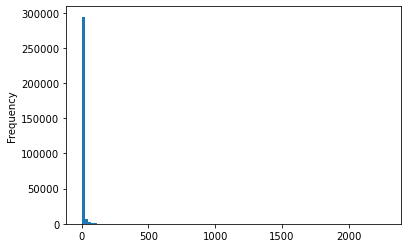

In [5]:
# Distribution of numerator:
df["helpful_numerator"].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

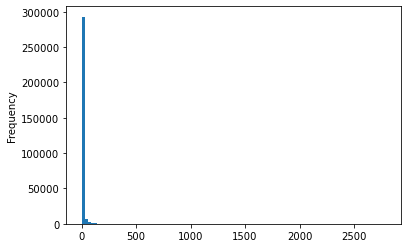

In [6]:
# Distribution of denominator:
df["helpful_denominator"].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

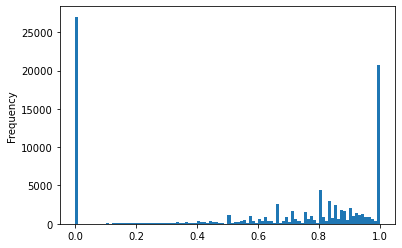

In [7]:
df["helpful_ratio"] = df["helpful_numerator"] / df["helpful_denominator"]
df["helpful_ratio"].plot.hist(bins=100)

In [8]:
len(df[df["helpful_ratio"] > 0.5])

63451

In [9]:
df["helpful_category"].value_counts()

unhelpful    235205
helpful       69726
Name: helpful_category, dtype: int64

In [10]:
review_lengths = [len(s) for s in df["reviewText"]]

In [11]:
max(review_lengths)

32364

In [12]:
min(review_lengths)

1

In [13]:
sum(review_lengths) / len(review_lengths)

775.9156989614044

<AxesSubplot:ylabel='Frequency'>

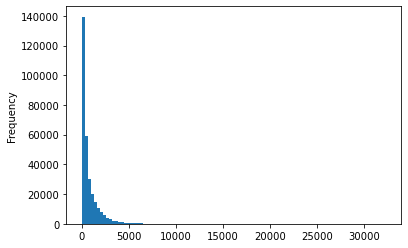

In [14]:
pd.Series(review_lengths).plot.hist(bins=100)

## Create train and test data

We have a big class imbalance in our dataset, we'll correct this by doing some undersampling on the negative class.

In [15]:
# Find out how many positive labels we have:
positive_samples = df[(df["helpful_category"] == "helpful")]
n_positive_samples = positive_samples.shape[0]

# Sample from negative class so we have the same amount:
negative_samples = df[(df["helpful_category"] == "unhelpful")].sample(n=n_positive_samples, random_state=42)

balanced_df = positive_samples.append(negative_samples)

# Add the label in binary form:
balanced_df["label"] = balanced_df["helpful_category"].map({"unhelpful": 0, "helpful": 1})

# Save just the X-y columns of the full balanced dataset:
fp = os.path.join(os.getcwd(), "data", "amazon", "full_balanced.csv")
balanced_df[["reviewText", "label"]].to_csv(fp, encoding="utf-8", index=False)

# Check balance:
balanced_df["label"].mean()

0.5

Next we trim down to a similar number of reviews as the yelp dataset.

In [16]:
sampled_df = balanced_df.sample(n=60_000, random_state=42)

# Check label balance of final sampled dataset:
sampled_df["label"].mean()

0.5004833333333333

Finally we randomly split into train (80% of records) and test and validation (10% each).

In [17]:
indices = list(sampled_df.index)
random.seed(42)
random.shuffle(indices)

train_size = int(len(sampled_df) * 0.8)
train_ix = indices[:train_size]
test_val_size = int(len(sampled_df) * 0.1)
val_ix = indices[train_size:train_size+test_val_size]
test_ix = indices[train_size+test_val_size:]

train = sampled_df.loc[train_ix]
val = sampled_df.loc[val_ix]
test = sampled_df.loc[test_ix]

print(f"Train:  {len(train)}")
print(f"Valid:  {len(val)}")
print(f"Test:   {len(test)}")

Train:  48000
Valid:  6000
Test:   6000


A final balance check on the data splits:

In [18]:
train["label"].mean()

0.5019791666666666

In [19]:
val["label"].mean()

0.487

In [20]:
test["label"].mean()

0.502

Since the process should be reproducible due to using random seeds, the following can be used as a rough checksum to make sure results match. The numbers should read:

* Train checksum = 61693485580800
* Test checksum = 7710874012800
* Validation checksum = 7715694614400

In [21]:
print(f"Train checksum      = {sum(train['unixReviewTime'])}")
print(f"Test checksum       = {sum(test['unixReviewTime'])}")
print(f"Validation checksum = {sum(val['unixReviewTime'])}")

Train checksum      = 61693485580800
Test checksum       = 7710874012800
Validation checksum = 7715694614400


Save the final datasets:

In [23]:
fp = os.path.join(os.getcwd(), "data", "amazon", "train.csv")
train.to_csv(fp, encoding="utf-8", index=False)
fp = os.path.join(os.getcwd(), "data", "amazon", "val.csv")
val.to_csv(fp, encoding="utf-8", index=False)
fp = os.path.join(os.getcwd(), "data", "amazon", "test.csv")
test.to_csv(fp, encoding="utf-8", index=False)